In [1]:
import os
import torch
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
label_class = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
class_label = {v: k for k, v in label_class.items()}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESIZE = 48
BATCH_SIZE = 128
PATH = 'D:\AI Courses\Semester 3\Computer Vision\Term Project\model'

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [15]:
train_base_path = 'images/train/'
val_base_path = 'images/validation/'

classes = list(label_class.values())

tr_paths, tr_lbls = [], []
val_paths, val_lbls = [], []

for each in classes:

    full_path = train_base_path + each + '/'
    num_items = os.listdir(full_path)
    for itm in num_items:
        tr_paths.append(full_path + itm)
        tr_lbls.append(class_label[each])
        
    full_path = val_base_path + each + '/'
    num_items = os.listdir(full_path)
    for itm in num_items:
        val_paths.append(full_path + itm)
        val_lbls.append(class_label[each])


tr_dict = {'img_id': tr_paths, 'label':tr_lbls}
val_dict = {'img_id': val_paths, 'label':val_lbls}

tr_df = pd.DataFrame(tr_dict)
val_df = pd.DataFrame(val_dict)

del tr_dict, val_dict, tr_lbls, val_lbls, tr_paths, val_paths, classes

In [16]:
tr_df.head()

,img_id,label
0,images/train/angry/0.jpg,0
1,images/train/angry/1.jpg,0
2,images/train/angry/10.jpg,0
3,images/train/angry/10002.jpg,0
4,images/train/angry/10016.jpg,0


In [17]:
val_df.head()

,img_id,label
0,images/validation/angry/10052.jpg,0
1,images/validation/angry/10065.jpg,0
2,images/validation/angry/10079.jpg,0
3,images/validation/angry/10095.jpg,0
4,images/validation/angry/10121.jpg,0


In [18]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, shuffle_data=True):

        self.df = df
        self.transform = transform
        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        img = Image.open(self.df.iloc[idx, 0]).convert("RGB")
        lbl = self.df.iloc[idx, 1]

        if self.transform:
            img = self.transform(img)

        return img, lbl

In [8]:
tr_dt = ImageDataset(tr_df, data_transforms['train'])
val_dt = ImageDataset(val_df, data_transforms['other'])

tr_loader = DataLoader(tr_dt, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dt, batch_size=BATCH_SIZE, shuffle=True)

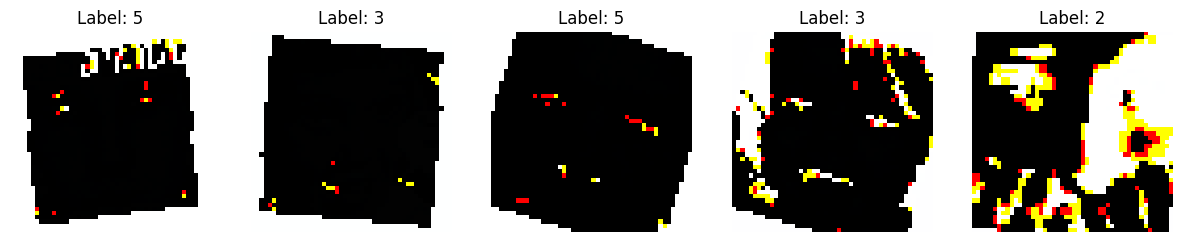

In [9]:
num_samples = 5
random_indices = np.random.randint(0, len(tr_dt), num_samples)

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image, label = tr_dt[idx]
    image = image.permute(1, 2, 0)
    axes[i].imshow(np.uint8(np.array(image)))
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [10]:
dataloaders = {
    'train': tr_loader,
    'validation': val_loader
}

del tr_loader, val_loader, tr_dt, val_dt

In [6]:
class Model(nn.Module):
    def __init__(self, num_features):
        
        super(Model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_features, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )
        
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 256, True),
            nn.BatchNorm1d(256),
            nn.Dropout1d(0.1),
            nn.Linear(256, 128, True),
            nn.BatchNorm1d(128),
            nn.Dropout1d(0.1),
            nn.Linear(128, 7, True),
        )


    
    def forward(self, x):

        # print(x.shape)
        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)

        return x

In [12]:
def train_model(model, criterion, optimizer, num_epochs=3, return_loss_acc=True):
    
    if return_loss_acc:
        tr_val_history = {'train': [], 'validation': []}
        tr_val_acc_history = {'train': [], 'validation': []}
    
    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase], unit='batch', position=0, leave=True) as pbar:
                for img, lbl in pbar:

                    pbar.set_description(f"Epoch {epoch+1}")

                    img = img.to(device)
                    lbl = lbl.to(device)
                    # print(labels)
                    outputs = model(img)
                    # print('--' * 35)
                    # print('model output shape:', outputs.shape)
                    # lbl_oh = F.one_hot(lbl, num_classes=num_classes).float()
                    # print('labels shape:', lbl.shape)
                    loss = criterion(outputs, lbl)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = (torch.max(outputs, 1))
                    # preds = F.one_hot(preds, num_classes=num_classes).float()
                    # print('--' * 35)
                    # print('prediction shape:', preds.shape)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == lbl.data)
                    # print('acc:', running_corrects)
                    # print()
                    pbar.set_postfix(loss=loss.item() / BATCH_SIZE, accuracy=torch.sum(preds == lbl.data).item() / BATCH_SIZE)
                    # sleep(0.1)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])

            if return_loss_acc:
                tr_val_history[phase].append(epoch_loss)
                tr_val_acc_history[phase].append(epoch_acc.item())
            
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
    if return_loss_acc:
        return model, (tr_val_history, tr_val_acc_history)
    return model

In [16]:
# model = models.efficientnet_b0(weights='DEFAULT')
# model.classifier = nn.Sequential(
#     nn.Dropout(0.2, inplace=True),
#     nn.Linear(1280, 7, bias=True)
# )
# model = model.to(device)
# model.fc = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(model.fc.in_features, 7),
#     nn.Softmax(dim=1)
# )
# model = model.to(device)
model = Model(3).to(device)
opt = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

EPOCH = 30

model_trained, history = train_model(model, criterion, opt, EPOCH)

--------------------------------------------------
Epoch 1/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8004, acc: 35.7566


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.5399, acc: 52.4464
--------------------------------------------------
Epoch 2/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.5547, acc: 49.5796


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2923, acc: 64.2321
--------------------------------------------------
Epoch 3/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.4631, acc: 54.5531


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2372, acc: 68.0179
--------------------------------------------------
Epoch 4/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.4237, acc: 57.5664


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1895, acc: 69.2143
--------------------------------------------------
Epoch 5/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3886, acc: 58.6814


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1482, acc: 70.9286
--------------------------------------------------
Epoch 6/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3606, acc: 60.2301


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1255, acc: 72.9107
--------------------------------------------------
Epoch 7/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3452, acc: 61.4027


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1120, acc: 72.6786
--------------------------------------------------
Epoch 8/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3311, acc: 61.3319


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0887, acc: 74.8929
--------------------------------------------------
Epoch 9/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3104, acc: 62.6195


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0770, acc: 74.8393
--------------------------------------------------
Epoch 10/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3028, acc: 63.2876


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0798, acc: 74.4643
--------------------------------------------------
Epoch 11/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2933, acc: 63.6416


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0914, acc: 74.0714
--------------------------------------------------
Epoch 12/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2820, acc: 64.3407


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0515, acc: 75.7857
--------------------------------------------------
Epoch 13/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2732, acc: 64.6018


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0359, acc: 76.8750
--------------------------------------------------
Epoch 14/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2625, acc: 65.5044


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0349, acc: 77.1071
--------------------------------------------------
Epoch 15/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2550, acc: 65.2434


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0236, acc: 77.8929
--------------------------------------------------
Epoch 16/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2543, acc: 65.2389


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0191, acc: 77.6964
--------------------------------------------------
Epoch 17/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2436, acc: 66.1283


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0104, acc: 78.3929
--------------------------------------------------
Epoch 18/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2337, acc: 66.2876


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0047, acc: 80.1071
--------------------------------------------------
Epoch 19/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2237, acc: 67.3805


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0088, acc: 78.3214
--------------------------------------------------
Epoch 20/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2244, acc: 67.1991


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.0032, acc: 79.0714
--------------------------------------------------
Epoch 21/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2200, acc: 67.2699


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9997, acc: 79.4821
--------------------------------------------------
Epoch 22/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2031, acc: 68.0133


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9960, acc: 79.2500
--------------------------------------------------
Epoch 23/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2063, acc: 67.9779


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9869, acc: 80.0893
--------------------------------------------------
Epoch 24/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1959, acc: 67.9115


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9892, acc: 79.8393
--------------------------------------------------
Epoch 25/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1964, acc: 68.4690


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9823, acc: 80.2679
--------------------------------------------------
Epoch 26/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1971, acc: 68.7920


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9879, acc: 80.0893
--------------------------------------------------
Epoch 27/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1848, acc: 69.0796


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9732, acc: 81.1250
--------------------------------------------------
Epoch 28/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1805, acc: 69.0310


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9684, acc: 80.5536
--------------------------------------------------
Epoch 29/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1800, acc: 68.9336


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9711, acc: 80.4286
--------------------------------------------------
Epoch 30/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.1658, acc: 69.9558


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 0.9686, acc: 80.7143


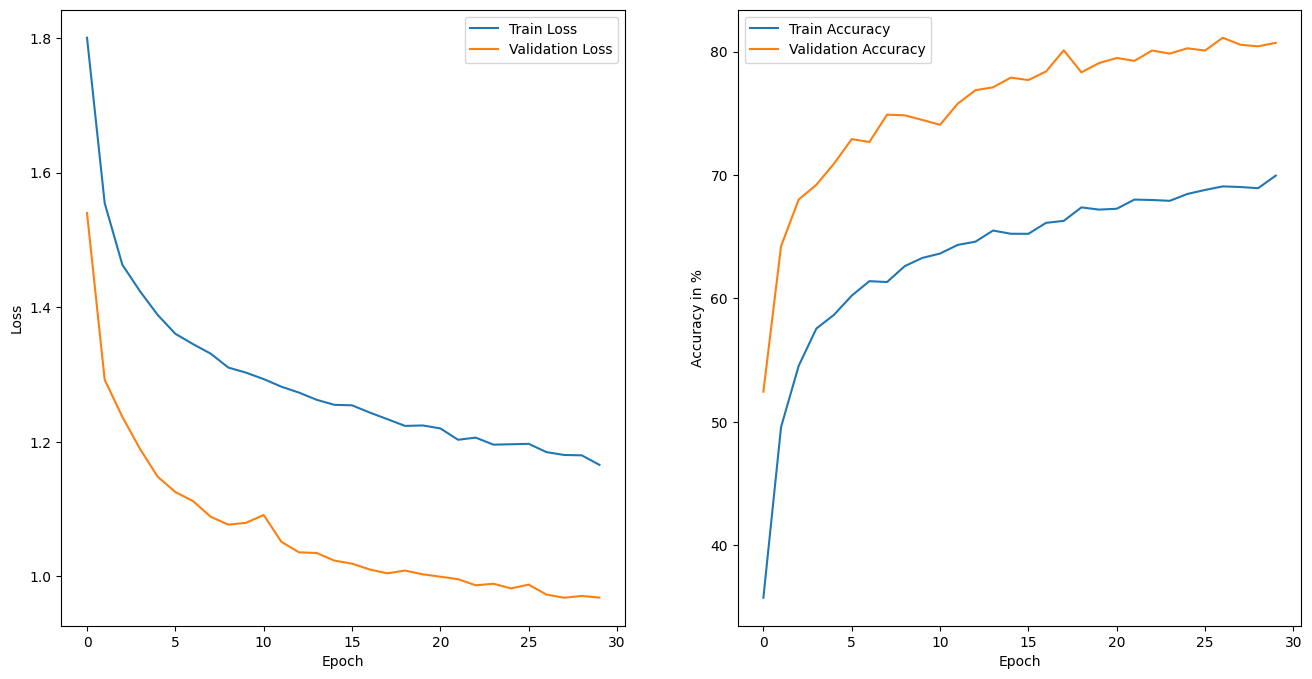

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history[0]['train'], label='Train Loss')
plt.plot(history[0]['validation'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history[1]['train'], label='Train Accuracy')
plt.plot(history[1]['validation'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy in %')
plt.legend()

In [29]:
torch.save(model_trained, './model/model.pth')

In [7]:
def renderer():
    PATH = './model/model.pth'
    face_classifier = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
    model = torch.load(PATH)
    model.eval()
    model.to(device)
    cap = cv.VideoCapture(0)



    while True:
        _, frame = cap.read()
        faces = face_classifier.detectMultiScale(frame)
        for (x,y,w,h) in faces:
            cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
            roi = frame[y:y + h, x:x + w]
            roi = cv.resize(roi, (48, 48), interpolation=cv.INTER_AREA)



            if np.sum([roi]) != 0:
                roi = data_transforms['other'](Image.fromarray(roi))
                roi = roi.reshape((1, roi.shape[0], roi.shape[1], roi.shape[2])).to(device)
                prediction = model(roi)
                label = label_class[torch.max(prediction, 1).indices.item()]
                label_position = (x, y)
                cv.putText(frame, label, label_position, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else:
                cv.putText(frame, 'No Faces', (30, 80), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv.imshow('Emotion Detector',frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

In [8]:
renderer()